
# Classifying Flowers using Transfer Learning in Keras

**Assignment:** Convolutional Neural Nets and Transfer Learning  
**Student:** Nataliia Kobrii (Student #: qq577503)  
**Date:** 2025/10/30



## Import. Environment Setup


In [1]:
import os, random, zipfile, shutil, math, glob, pathlib, collections
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
EPOCHS = 15
INITIAL_LR = 1e-3
FINETUNE_LR = 1e-4
ALL_LR = 5e-5
PREFETCH = tf.data.AUTOTUNE


## Dataset's download


In [2]:
import os, pandas as pd, glob, tensorflow as tf

url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

dataset_path = tf.keras.utils.get_file(
    "flower_photos",
    origin=url,
    extract=True
)

root = os.path.join(os.path.dirname(dataset_path), "flower_photos")

if os.path.exists(root):
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
    print("Classes:", classes)
else:
    raise FileNotFoundError("flower_photos folder was not found after extraction.")

# Index image filepaths and labels
filepaths, labels = [], []
for cls in classes:
    folder = os.path.join(root, cls)
    for fp in glob.glob(os.path.join(folder, "*")):
        if fp.lower().endswith((".jpg", ".jpeg", ".png")):
            filepaths.append(fp)
            labels.append(cls)

df = pd.DataFrame({"filepath": filepaths, "label": labels})
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print(df.head(), "\nCounts by class:\n", df['label'].value_counts())

Classes: ['daisy', 'dandelion', 'flower_photos', 'roses', 'sunflowers', 'tulips']
                                            filepath       label
0  /Users/natalikobrii/.keras/datasets/flower_pho...       daisy
1  /Users/natalikobrii/.keras/datasets/flower_pho...  sunflowers
2  /Users/natalikobrii/.keras/datasets/flower_pho...      tulips
3  /Users/natalikobrii/.keras/datasets/flower_pho...   dandelion
4  /Users/natalikobrii/.keras/datasets/flower_pho...   dandelion 
Counts by class:
 label
dandelion     898
tulips        799
sunflowers    699
roses         641
daisy         633
Name: count, dtype: int64



## Train/Test split (80/20)


In [3]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=SEED, stratify=df['label']
)
print("Train size:", len(train_df), " Test size:", len(test_df))
print("Train distribution:\n", train_df['label'].value_counts(normalize=True))
print("Test distribution:\n", test_df['label'].value_counts(normalize=True))


Train size: 2936  Test size: 734
Train distribution:
 label
dandelion     0.244891
tulips        0.217643
sunflowers    0.190395
roses         0.174728
daisy         0.172343
Name: proportion, dtype: float64
Test distribution:
 label
dandelion     0.243869
tulips        0.217984
sunflowers    0.190736
roses         0.174387
daisy         0.173025
Name: proportion, dtype: float64



## TensorFlow Data input pipeline


In [4]:
def load_and_preprocess(path, label_index):
    # Read image, decode, resize, and apply VGG16 preprocess_input
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, label_index

# Data Augmentation (for training)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augmentation")

class_names = classes
class_to_index = {c:i for i, c in enumerate(class_names)}
num_classes = len(class_names)

def make_ds(dataframe, augment=False, shuffle=False):
    paths = dataframe['filepath'].values
    y = dataframe['label'].map(class_to_index).values
    ds = tf.data.Dataset.from_tensor_slices((paths, y))
    ds = ds.map(load_and_preprocess, num_parallel_calls=PREFETCH)
    if shuffle:
        ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_SIZE)
    if augment:
        # apply augmentation only on images (x)
        def aug_map(x, y):
            return data_augmentation(x, training=True), y
        ds = ds.map(aug_map, num_parallel_calls=PREFETCH)
    return ds.prefetch(PREFETCH)

# Build train/val from train_df
train_df2, val_df = train_test_split(
    train_df, test_size=VAL_SPLIT, random_state=SEED, stratify=train_df['label']
)

train_ds = make_ds(train_df2, augment=True, shuffle=True)
val_ds   = make_ds(val_df, augment=False, shuffle=False)
test_ds  = make_ds(test_df, augment=False, shuffle=False)

len_train_steps = math.ceil(len(train_df2) / BATCH_SIZE)
len_val_steps   = math.ceil(len(val_df) / BATCH_SIZE)
len_test_steps  = math.ceil(len(test_df) / BATCH_SIZE)

len_train_steps, len_val_steps, len_test_steps


(74, 19, 23)


## Model builders


In [5]:
def build_head(x, dropout=0.3, units=256):
    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.BatchNormalization(name="bn1")(x)
    x = layers.Dropout(dropout, name="drop1")(x)
    x = layers.Dense(units, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4), name="fc1")(x)
    x = layers.BatchNormalization(name="bn2")(x)
    x = layers.Dropout(dropout, name="drop2")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="preds")(x)
    return outputs

def build_model(trainable_until=None):
    # Base VGG16
    base = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
    if trainable_until is None:
        base.trainable = False
    else:
        # Freeze up to layer index 'trainable_until' (exclusive)
        for i, layer in enumerate(base.layers):
            layer.trainable = i >= trainable_until
    
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    # Augmentation
    x = inputs
    x = base(x, training=False)
    outputs = build_head(x)
    model = keras.Model(inputs, outputs, name="VGG16_transfer")
    return model, base

def compile_model(model, lr):
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

early_stop = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True)
reduce_lr  = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)


## Model 1. Freeze all VGG16 layers

In [6]:
# Freeze all
model1, base1 = build_model(trainable_until=None)
compile_model(model1, INITIAL_LR)
model1.summary()

hist1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

test_loss1, test_acc1 = model1.evaluate(test_ds, verbose=0)
print("Model 1. Test Accuracy:", round(test_acc1, 4))


Model: "VGG16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,630 (56.65 MB)

 Trainable params: 134,406 (525.02 KB)

 Non-trainable params: 14,716,224 (56.14 MB)

Epoch 1/15
74/74 - 228s - 3s/step - accuracy: 0.6393 - loss: 1.1075 - val_accuracy: 0.8350 - val_loss: 0.5705 - learning_rate: 1.0000e-03
Epoch 2/15
74/74 - 252s - 3s/step - accuracy: 0.7879 - loss: 0.6389 - val_accuracy: 0.8673 - val_loss: 0.4674 - learning_rate: 1.0000e-03
Epoch 3/15
74/74 - 237s - 3s/step - accuracy: 0.8156 - loss: 0.5446 - val_accuracy: 0.8759 - val_loss: 0.4430 - learning_rate: 1.0000e-03
Epoch 4/15
74/74 - 235s - 3s/step - accuracy: 0.8245 - loss: 0.5209 - val_accuracy: 0.8878 - val_loss: 0.4120 - learning_rate: 1.0000e-03
Epoch 5/15
74/74 - 231s - 3s/step - accuracy: 0.8356 - loss: 0.4824 - val_accuracy: 0.8622 - val_loss: 0.4382 - learning_rate: 1.0000e-03
Epoch 6/15
74/74 - 226s - 3s/step - accuracy: 0.8484 - loss: 0.4676 - val_accuracy: 0.8810 - val_loss: 0.4021 - learning_rate: 1.0000e-03
Epoch 7/15
74/74 - 232s - 3s/step - accuracy: 0.8773 - loss: 0.3910 - val_accuracy: 0.8827 - val_loss: 0.4165 - learning_rate: 1.0000e-03
Epoch 8/15

Epoch 8: ReduceLROnPla

## Model 2. Unfreeze VGG16 block5 and fine-tune

In [7]:
# Identify the start index of block5 in VGG16
tmp_base = VGG16(weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,))
block5_start = None
for i, layer in enumerate(tmp_base.layers):
    if layer.name.startswith("block5_conv1"):
        block5_start = i
        break
del tmp_base

model2, base2 = build_model(trainable_until=block5_start)
# When unfreezing part of the base, use a smaller LR
compile_model(model2, FINETUNE_LR)
model2.summary()

hist2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

test_loss2, test_acc2 = model2.evaluate(test_ds, verbose=0)
print("Model 2. Test Accuracy:", round(test_acc2, 4))


Model: "VGG16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,630 (56.65 MB)

 Trainable params: 7,213,830 (27.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

Epoch 1/15
74/74 - 448s - 6s/step - accuracy: 0.6508 - loss: 1.0526 - val_accuracy: 0.7772 - val_loss: 1.0758 - learning_rate: 1.0000e-04
Epoch 2/15
74/74 - 264s - 4s/step - accuracy: 0.8407 - loss: 0.4897 - val_accuracy: 0.8401 - val_loss: 0.6248 - learning_rate: 1.0000e-04
Epoch 3/15
74/74 - 258s - 3s/step - accuracy: 0.8880 - loss: 0.3519 - val_accuracy: 0.8810 - val_loss: 0.4231 - learning_rate: 1.0000e-04
Epoch 4/15
74/74 - 256s - 3s/step - accuracy: 0.8969 - loss: 0.3064 - val_accuracy: 0.9150 - val_loss: 0.3151 - learning_rate: 1.0000e-04
Epoch 5/15
74/74 - 264s - 4s/step - accuracy: 0.9280 - loss: 0.2478 - val_accuracy: 0.9167 - val_loss: 0.2693 - learning_rate: 1.0000e-04
Epoch 6/15
74/74 - 254s - 3s/step - accuracy: 0.9344 - loss: 0.2192 - val_accuracy: 0.8929 - val_loss: 0.3590 - learning_rate: 1.0000e-04
Epoch 7/15

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
74/74 - 257s - 3s/step - accuracy: 0.9463 - loss: 0.1893 - val_accuracy: 0.9048 - va

## Model 3. Unfreeze all VGG16 layers and fine-tune fully

In [8]:
# Unfreeze all layers
model3, base3 = build_model(trainable_until=0)
for layer in model3.layers:
    layer.trainable = True
compile_model(model3, ALL_LR)
model3.summary()

hist3 = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)

test_loss3, test_acc3 = model3.evaluate(test_ds, verbose=0)
print("Model 3. Test Accuracy:", round(test_acc3, 4))


Model: "VGG16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (GlobalAveragePooling2D)    │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,630 (56.65 MB)

 Trainable params: 14,849,094 (56.64 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/15
74/74 - 626s - 8s/step - accuracy: 0.5162 - loss: 1.5001 - val_accuracy: 0.7211 - val_loss: 1.0902 - learning_rate: 5.0000e-05
Epoch 2/15
74/74 - 630s - 9s/step - accuracy: 0.7466 - loss: 0.7871 - val_accuracy: 0.8129 - val_loss: 0.6003 - learning_rate: 5.0000e-05
Epoch 3/15
74/74 - 683s - 9s/step - accuracy: 0.8122 - loss: 0.5856 - val_accuracy: 0.8146 - val_loss: 0.7715 - learning_rate: 5.0000e-05
Epoch 4/15

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
74/74 - 682s - 9s/step - accuracy: 0.8445 - loss: 0.4880 - val_accuracy: 0.8197 - val_loss: 0.6228 - learning_rate: 5.0000e-05
Epoch 5/15
74/74 - 636s - 9s/step - accuracy: 0.8769 - loss: 0.4093 - val_accuracy: 0.8656 - val_loss: 0.3916 - learning_rate: 2.5000e-05
Epoch 6/15
74/74 - 634s - 9s/step - accuracy: 0.8965 - loss: 0.3444 - val_accuracy: 0.9099 - val_loss: 0.3089 - learning_rate: 2.5000e-05
Epoch 7/15
74/74 - 638s - 9s/step - accuracy: 0.9037 - loss: 0.3042 - val_accuracy: 0.8605 - va

## Learning Curves

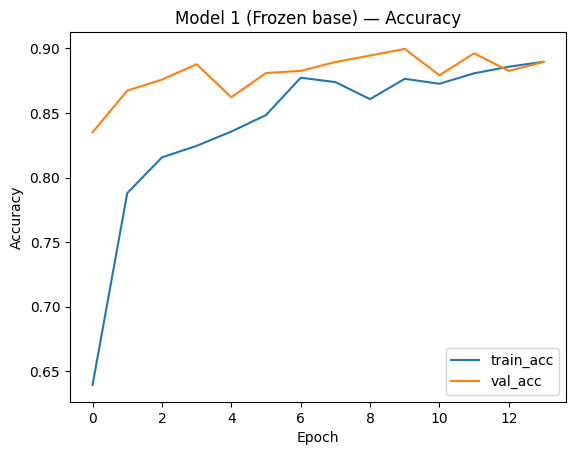

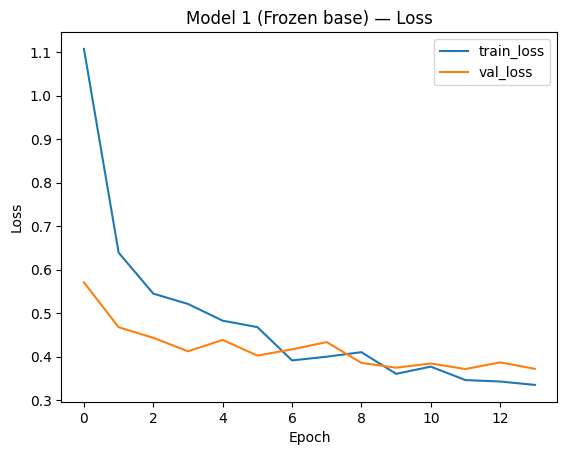

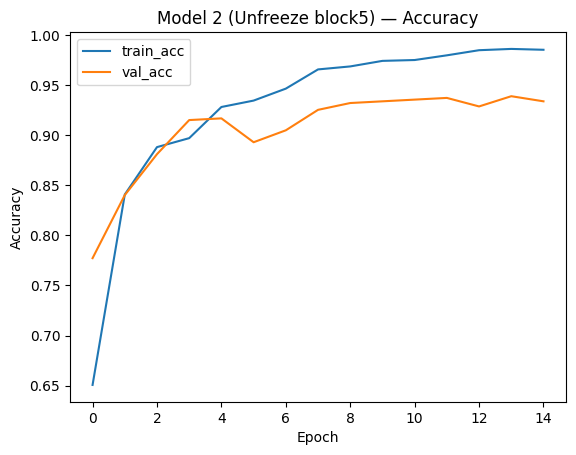

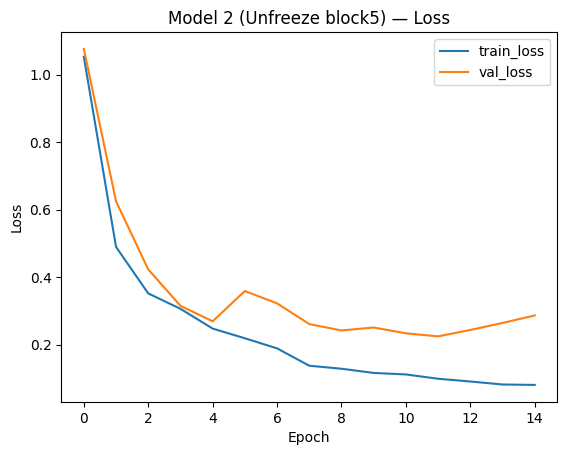

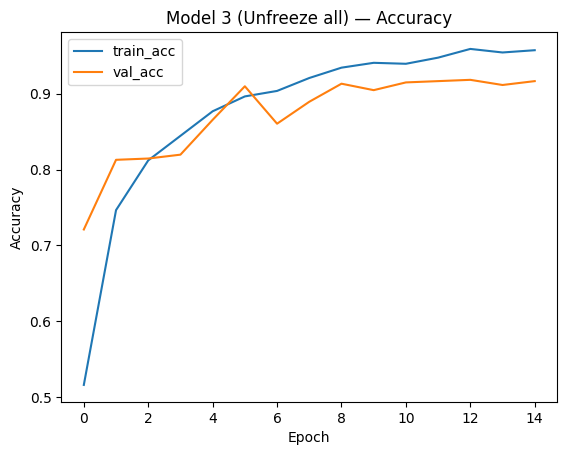

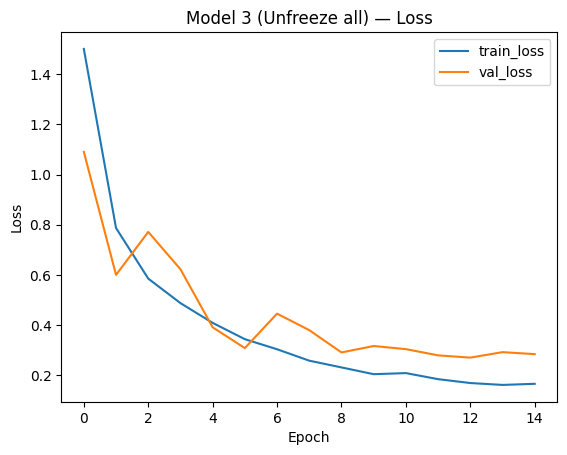

In [9]:
def plot_history(hist, title):
    acc = hist.history.get("accuracy", [])
    val_acc = hist.history.get("val_accuracy", [])
    loss = hist.history.get("loss", [])
    val_loss = hist.history.get("val_loss", [])
    
    # Accuracy
    plt.figure()
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title + " — Accuracy")
    plt.legend()
    plt.show()
    
    # Loss
    plt.figure()
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " — Loss")
    plt.legend()
    plt.show()

plot_history(hist1, "Model 1 (Frozen base)")
plot_history(hist2, "Model 2 (Unfreeze block5)")
plot_history(hist3, "Model 3 (Unfreeze all)")


## Final Evaluation & Comparison

In [13]:
# Collect final metrics
def final_metrics(hist, test_acc):
    train_acc = max(hist.history.get("accuracy", [float('nan')]))
    val_acc = max(hist.history.get("val_accuracy", [float('nan')]))
    return train_acc, val_acc, test_acc

m1 = final_metrics(hist1, test_acc1)
m2 = final_metrics(hist2, test_acc2)
m3 = final_metrics(hist3, test_acc3)

results_df = pd.DataFrame({
    "Model": ["Model 1 – Frozen", "Model 2 – Block5", "Model 3 – All"],
    "Best Train Acc": [m1[0], m2[0], m3[0]],
    "Best Val Acc":   [m1[1], m2[1], m3[1]],
    "Test Acc":       [m1[2], m2[2], m3[2]],
}).sort_values("Test Acc", ascending=False).reset_index(drop=True)

float_cols = results_df.select_dtypes(include="number").columns
results_df.style.format({col: "{:.4f}".format for col in float_cols})


,Model,Best Train Acc,Best Val Acc,Test Acc
0,Model 2 – Block5,0.9859,0.9388,0.9305
1,Model 3 – All,0.9591,0.9184,0.9183
2,Model 1 – Frozen,0.8897,0.8997,0.8801


Unique labels in test set: [np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(5)]
Number of class_names: 6
Classification Report (best model):

              precision    recall  f1-score   support

       daisy       0.97      0.92      0.94       127
   dandelion       0.96      0.94      0.95       179
       roses       0.86      0.89      0.88       128
  sunflowers       0.92      0.93      0.92       140
      tulips       0.88      0.90      0.89       160

    accuracy                           0.92       734
   macro avg       0.92      0.92      0.92       734
weighted avg       0.92      0.92      0.92       734



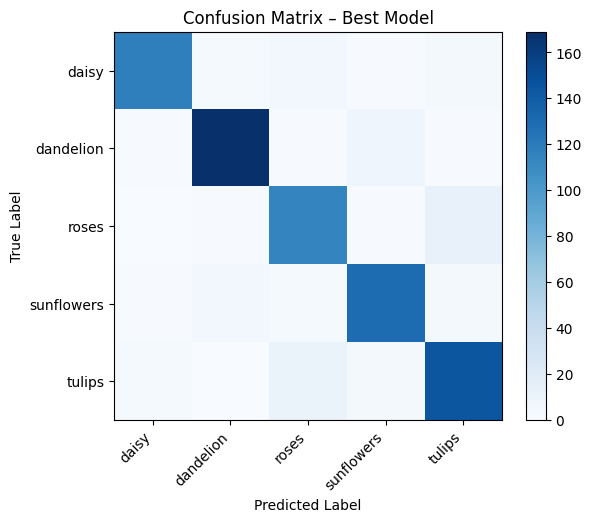

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Collect predictions
y_true, y_pred = [], []
for batch_x, batch_y in test_ds:
    y_true.extend(batch_y.numpy().tolist())
    probs = model3.predict(batch_x, verbose=0)  # use your best model
    y_pred.extend(np.argmax(probs, axis=1).tolist())

unique_labels = sorted(np.unique(y_true))
print("Unique labels in test set:", unique_labels)
print("Number of class_names:", len(class_names))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

print("Classification Report (best model):\n")
print(
    classification_report(
        y_true, y_pred,
        labels=unique_labels,
        target_names=[class_names[i] for i in unique_labels]
    )
)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix – Best Model")
plt.colorbar()
tick_marks = np.arange(len(unique_labels))
plt.xticks(tick_marks, [class_names[i] for i in unique_labels], rotation=45, ha='right')
plt.yticks(tick_marks, [class_names[i] for i in unique_labels])
plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



## Conclusion

**Model 1 (Frozen Base):**
Achieved a training accuracy of 88.97%, validation accuracy of 89.97%, and test accuracy of 88.01%.
Since all convolutional layers were frozen, the model relied only on pre-trained ImageNet features and could not fully adapt to the flower dataset. This limited its ability to learn more specific patterns, resulting in the lowest accuracy among the three.

**Model 2 (Unfrozen Block 5):**
Reached the highest performance overall: train accuracy 98.59%, validation accuracy 93.88%, and test accuracy 93.05%.
By unfreezing only the last convolutional block, the model fine-tuned high-level features relevant to flower shapes and colors while retaining the robust low-level filters learned from ImageNet. This balance between adaptation and generalization produced the best results.

**Model 3 (All Layers Trainable):**
Recorded a training accuracy of 95.91%, validation accuracy of 91.84%, and test accuracy of 91.83%.
Although training accuracy was high, full fine-tuning caused some overfitting, namely the model began to memorize training data rather than generalize.

**Overall:**
Model 2 demonstrated the best generalization and stability, confirming that partial fine-tuning is the most effective strategy for this dataset.